In [2]:
import holidays
import pandas as pd
from datetime import datetime

us_holidays = holidays.country_holidays('US', years=[2023])  

# Get the week numbers for each holiday
holiday_weeks = set()
for date in us_holidays:
    week_number = datetime.strptime(str(date), "%Y-%m-%d").isocalendar()[1]
    holiday_weeks.add(week_number)
    
print(holiday_weeks)

{1, 3, 36, 8, 41, 45, 47, 52, 22, 25, 27}


In [3]:
import glob
import numpy as np

def aggregate_csv_files(directory_path):
    all_files = glob.glob(f"{directory_path}/*.csv")
    df_list = []

    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)

    # Concatenate all DataFrames
    combined_df = pd.concat(df_list, ignore_index=True)

    # Drop rows with NaN or infinite values
    combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_df.dropna(inplace=True)

    # Select the necessary columns
    aggregated_df = combined_df[['date', '1wk_WIS', '1_week_roc', 
                                 'is_wis_above_avg', '1st_deriv_stencil', 
                                 'week_of_year', 'moving_avg_WIS', 
                                 'lagged_1wk_WIS']]

    return aggregated_df

directory_path = './hosp_roc'
aggregated_data = aggregate_csv_files(directory_path)
aggregated_data

,date,1wk_WIS,1_week_roc,is_wis_above_avg,1st_deriv_stencil,week_of_year,moving_avg_WIS,lagged_1wk_WIS
2,2023-10-28,19.51,0.320000,0,7.333333,43,13.273333,13.51
3,2023-11-04,6.51,0.181818,0,4.166667,44,13.176667,19.51
4,2023-11-11,45.84,0.205128,0,27.750000,45,23.953333,6.51
5,2023-11-18,11.54,0.851064,0,16.416667,46,21.296667,45.84
6,2023-11-25,37.36,-0.034483,0,25.750000,47,31.580000,11.54
...,...,...,...,...,...,...,...,...
1243,2024-03-02,7.56,-0.173077,0,-1.000000,9,4.150000,1.44
1244,2024-03-09,13.41,0.209302,0,14.166667,10,7.470000,7.56
1245,2024-03-16,2.61,0.230769,0,-1.750000,11,7.860000,13.41
1246,2024-03-23,2.18,-0.218750,0,-8.000000,12,6.066667,2.61


In [4]:
df = aggregated_data

df['holiday_week'] = df['week_of_year'].apply(lambda x: 1 if x in holiday_weeks else 0)

df

,date,1wk_WIS,1_week_roc,is_wis_above_avg,1st_deriv_stencil,week_of_year,moving_avg_WIS,lagged_1wk_WIS,holiday_week
2,2023-10-28,19.51,0.320000,0,7.333333,43,13.273333,13.51,0
3,2023-11-04,6.51,0.181818,0,4.166667,44,13.176667,19.51,0
4,2023-11-11,45.84,0.205128,0,27.750000,45,23.953333,6.51,1
5,2023-11-18,11.54,0.851064,0,16.416667,46,21.296667,45.84,0
6,2023-11-25,37.36,-0.034483,0,25.750000,47,31.580000,11.54,1
...,...,...,...,...,...,...,...,...,...
1243,2024-03-02,7.56,-0.173077,0,-1.000000,9,4.150000,1.44,0
1244,2024-03-09,13.41,0.209302,0,14.166667,10,7.470000,7.56,0
1245,2024-03-16,2.61,0.230769,0,-1.750000,11,7.860000,13.41,0
1246,2024-03-23,2.18,-0.218750,0,-8.000000,12,6.066667,2.61,0


In [5]:
"""Prepare the data."""

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

df = aggregated_data
df.dropna(inplace=True)

features = ['1_week_roc', 
            '1st_deriv_stencil', 
            'week_of_year', 
            'moving_avg_WIS', 
            'lagged_1wk_WIS',
            'holiday_week']
X = df[features]
y = df['is_wis_above_avg']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
"""Train and evaluate the RF model."""

from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       155
           1       0.81      0.67      0.73        69

    accuracy                           0.85       224
   macro avg       0.83      0.80      0.81       224
weighted avg       0.85      0.85      0.84       224



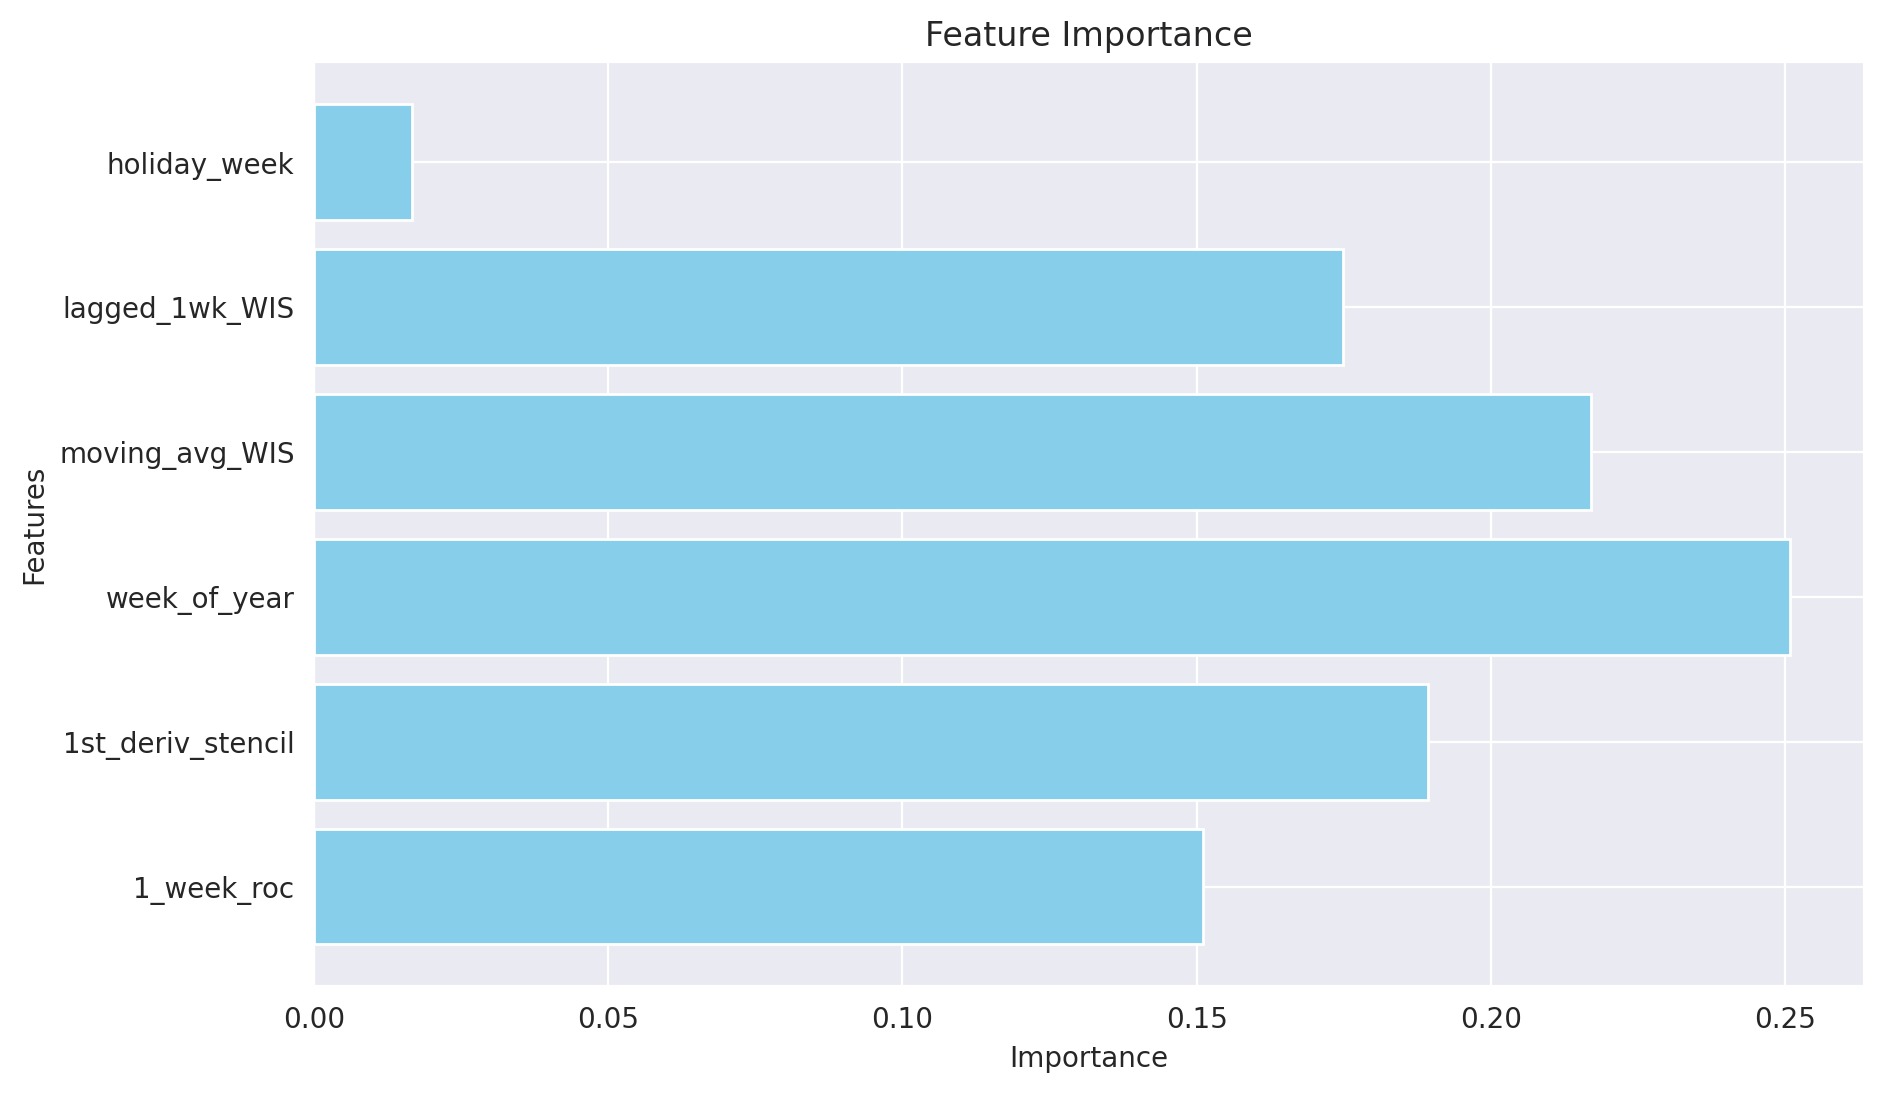

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature Importances
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Plot Feature Importances
plt.figure(figsize=(10, 6), dpi=200)
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

In [16]:
"""Recursive Feature Elimination -- 5 Features"""

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model for RFE
model = LogisticRegression()

# Initialize RFE with the logistic regression model
rfe = RFE(estimator=model, n_features_to_select=5)

# Fit RFE
rfe = rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# Reduce the dataset to selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

# Train Random Forest model with reduced features
rf_model_rfe = RandomForestClassifier(random_state=42)
rf_model_rfe.fit(X_train_rfe, y_train)

# Evaluate the reduced model
y_pred_rfe = rf_model_rfe.predict(X_test_rfe)
print(classification_report(y_test, y_pred_rfe))

Selected Features: Index(['1_week_roc', 'week_of_year', 'moving_avg_WIS', 'lagged_1wk_WIS',
       'holiday_week'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       155
           1       0.77      0.71      0.74        69

    accuracy                           0.84       224
   macro avg       0.82      0.81      0.81       224
weighted avg       0.84      0.84      0.84       224



In [17]:
"""Recursive Feature Elimination -- 4 Features"""

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model for RFE
model = LogisticRegression()

# Initialize RFE with the logistic regression model
rfe = RFE(estimator=model, n_features_to_select=4)

# Fit RFE
rfe = rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# Reduce the dataset to selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

# Train Random Forest model with reduced features
rf_model_rfe = RandomForestClassifier(random_state=42)
rf_model_rfe.fit(X_train_rfe, y_train)

# Evaluate the reduced model
y_pred_rfe = rf_model_rfe.predict(X_test_rfe)
print(classification_report(y_test, y_pred_rfe))

Selected Features: Index(['1_week_roc', 'week_of_year', 'moving_avg_WIS', 'holiday_week'], dtype='object')
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       155
           1       0.63      0.59      0.61        69

    accuracy                           0.77       224
   macro avg       0.73      0.72      0.72       224
weighted avg       0.76      0.77      0.77       224



### Cross Validation

In [18]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

features = ['1_week_roc', 
            '1st_deriv_stencil', 
            'week_of_year', 
            'moving_avg_WIS', 
            'lagged_1wk_WIS',
            'holiday_week']
X = df[features]
y = df['is_wis_above_avg']

rf_model = RandomForestClassifier(random_state=42)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='roc_auc')

print("Cross-validation AUC scores:", cv_scores)
print("Mean cross-validation AUC score:", np.mean(cv_scores))

Cross-validation AUC scores: [0.8126414  0.8491233  0.85397813 0.86418406 0.83434535]
Mean cross-validation AUC score: 0.8428544494720965


In [19]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X, y)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


In [20]:
from sklearn.ensemble import RandomForestClassifier

# Define the best parameters
best_params = {'max_depth': None, 
               'min_samples_leaf': 2, 
               'min_samples_split': 5, 
               'n_estimators': 300}

# Initialize the model with the best parameters
final_rf_model = RandomForestClassifier(**best_params, random_state=42)

# Train the model on the entire training dataset
final_rf_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, random_state=42)

In [21]:
from sklearn.metrics import classification_report, roc_auc_score

# Make predictions on the test set
y_pred_final = final_rf_model.predict(X_test)
y_pred_prob_final = final_rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
auc_score_final = roc_auc_score(y_test, y_pred_prob_final)
classification_report_final = classification_report(y_test, y_pred_final)

# Print the evaluation metrics
print("Final Model AUC Score:", auc_score_final)
print("Final Model Classification Report:\n", classification_report_final)


Final Model AUC Score: 0.8647966339410939
Final Model Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.88       155
           1       0.78      0.65      0.71        69

    accuracy                           0.83       224
   macro avg       0.82      0.78      0.80       224
weighted avg       0.83      0.83      0.83       224

